In [168]:
import numpy as np
import pandas as pd
import requests
import bs4
from matplotlib import pyplot as plt
import seaborn as sns

pd.set_option('max_colwidth', 255)
pd.set_option('display.max_rows', 500)

## Links Úteis

https://cliqueeconomia.curitiba.pr.gov.br/pesquisa-produtos/?categoria=5&termo=leite

https://dadosabertos.c3sl.ufpr.br/curitiba/CliqueEconomia/

## Funções

In [169]:
def barplot(group:str, agg:str, agg_name:str, data:pd.DataFrame, agg_func:str, title:str = '', orient:str = 'h', subplot:plt.subplot = None, grid:list = None, title_font_size:int =10, figure= plt.figure, figsize=(10,5),label=True, sort: bool = True):
    
    # group data
    aux = data[[group,agg]].groupby(group).agg(agg_func).reset_index().rename(columns={agg:agg_name})

    if sort:
        aux = aux.sort_values(agg_name, ascending=False)
        
    # plot
    if subplot:
        subplot(grid)
    else:
        figure(figsize=figsize)

    # plot configs
    plt.title(title, fontsize=title_font_size)
    plt.xticks(rotation = 45)

    # figure
    if orient == 'h':
        g = sns.barplot(x = group, y = agg_name, data = aux)
    else:
        g = sns.barplot(x = agg_name, y = group, data = aux)

    if label:
        for i in g.containers:
            g.bar_label(i, color = 'white',label_type='center')
    else:
        pass

## Carregando Dados

In [170]:
link = 'https://dadosabertos.c3sl.ufpr.br/curitiba/CliqueEconomia/'
res = requests.get(link, headers={'Content-Type':'text/csv'})
soup = bs4.BeautifulSoup(res.content)

files_names = [i.text for i in soup.findAll('a') if i.text.find('_Clique_Economia_-_Cotacoes_-_Base_de_Dados.csv') != -1] 

In [313]:
# data_list = list()

# for file in files_names[30:100]:
#     # data = '2024-06-18'
#     link = f'https://dadosabertos.c3sl.ufpr.br/curitiba/CliqueEconomia/{file}'
#     res = requests.get(link, headers={'Content-Type':'text/csv'})
#     content = str(res.content.decode('iso8859-1'))
#     content = content.split('\n')

#     data_aux = pd.DataFrame([row.split(';') for row in content][1::], columns=[row.split(';') for row in content][0]).to_dict(orient='records')

#     # data = pd.concat([data, data_aux],axis=0)
#     # print(data.columns)

#     data_list = data_list + data_aux

data = pd.DataFrame(data_list)

data.shape


(408572, 12)

## Análise Descritiva dos Dados

- Quantidade de Dados
- Dados Nulos
- Tipo de Variáveis
- Estatística Descritiva

### Dimensão dos Dados

In [314]:
print(f'Número de Linhas: {data.shape[0]}')
print(f'Número de Colunas: {data.shape[1]}')

Número de Linhas: 408572
Número de Colunas: 12


### Dados Nulos

In [315]:
data.isna().sum()

data_pesquisa        0
id_empresa           0
rede                 0
endereco_completo    0
codigo_categoria     0
id_produto           0
descricao            0
preco_regular        0
preco_atacado        0
preco_atacado_qtd    0
preco_promocao       0
preco_fidelidade     0
dtype: int64

### Tipos de Variáveis

In [316]:
data['preco_regular'] = data['preco_regular'].astype('float64')
data['preco_fidelidade'] = data['preco_fidelidade'].astype('float64')
data['preco_atacado'] = data['preco_atacado'].astype('float64')
data['preco_atacado_qtd'] = data['preco_atacado_qtd'].astype('float64')
data['preco_promocao'] = data['preco_promocao'].astype('float64')
# data['id_produto'] = data['id_produto'].astype('float64')

data['descricao'] = data['descricao'].str.strip()
data['descricao'] = data['descricao'].str.replace('- SOFT', '-SOFT')
# data['descricao'] = data['descricao'].str.replace(' - ', ' | ')

### Estatística Descritiva

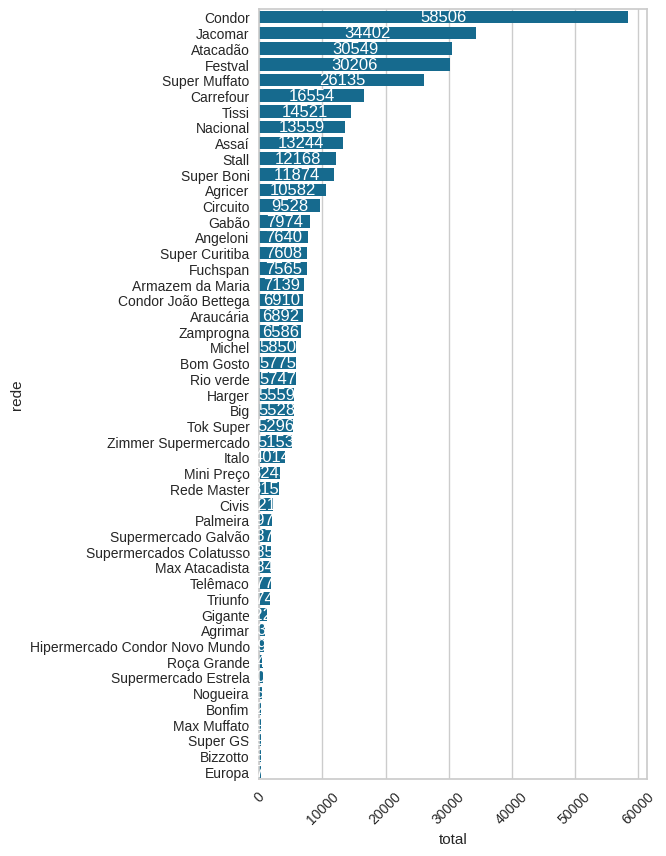

In [317]:
barplot(group = 'rede', 
        agg='id_produto',
        agg_func='count',
        agg_name='total',
        data=data,
        orient='v',
        figsize=(5,10))

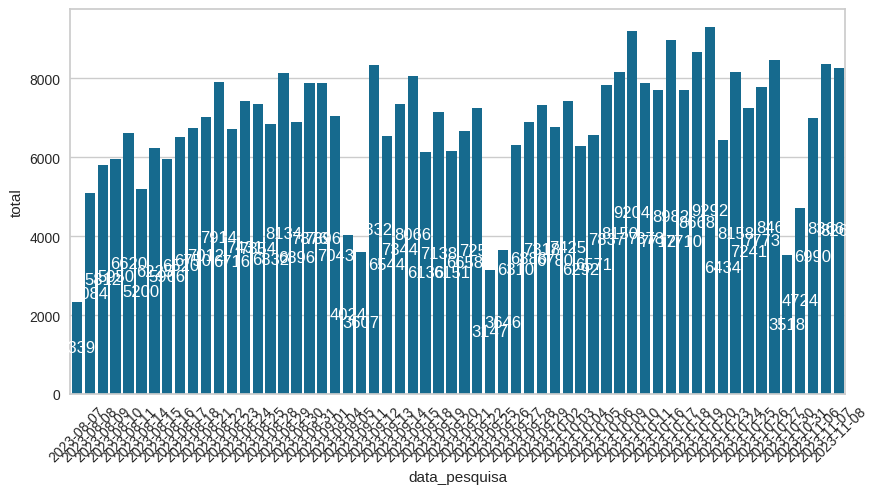

In [318]:
barplot(group = 'data_pesquisa', 
        agg='id_produto',
        agg_func='count',
        agg_name='total',
        data=data,
        sort=False)

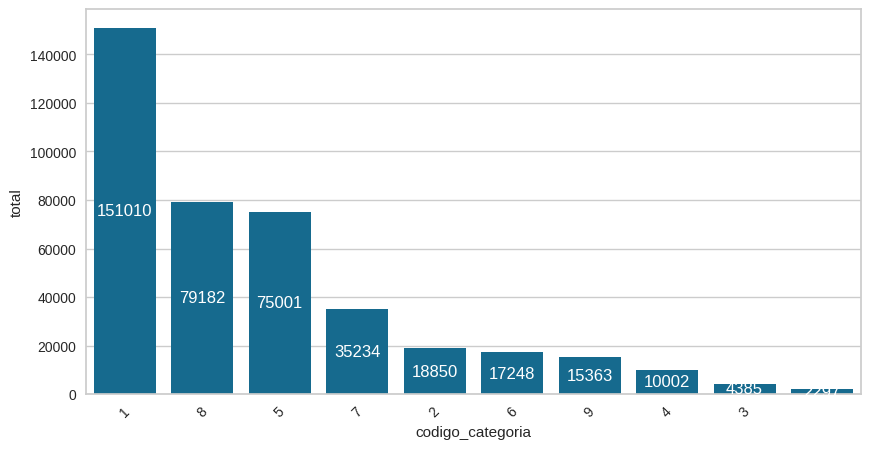

In [319]:
barplot(group = 'codigo_categoria', 
        agg='id_produto',
        agg_func='count',
        agg_name='total',
        data=data)

## Filtrando Variáveis

## Feature Engineering

- Preços médios
    - Produtos com promoção
    - Produtos sem promoção
- Distribuição das promoções
    - Frequencia das promoções
    - Força das promoções
- Variedade de produtos
    - Diversidade das categorias
- Localização
    - Região da cidade
- Variação diária de preços
- Tendência de promoções em dias específicos

In [320]:
codigos_categorias = data.loc[data['codigo_categoria'] != '', ['descricao','codigo_categoria']].drop_duplicates().set_index('descricao')
codigos_categorias_dict = codigos_categorias.to_dict()['codigo_categoria']
data.loc[data['codigo_categoria'] == '','codigo_categoria'] = data.loc[data['codigo_categoria'] == '','descricao'].map(codigos_categorias_dict)
nomes_categorias = {
    '1':'produtos_basicos',
    '2':'alimentos_especiais',
    '3':'produtos_organicos',
    '4':'paes',
    '5':'carnes_e_frios',
    '6':'material_de_higiene',
    '7':'material_de_limpeza',
    '8':'hortifruti',
    '9':'bebidas'
}
data['nome_categoria'] = data['codigo_categoria'].map(nomes_categorias)

In [321]:
data['preco'] = data.apply(lambda x: 
                           x['preco_promocao'] if (x['preco_regular'] >= 0) & (x['preco_promocao'] > 0) else 
                           x['preco_fidelidade'] if (x['preco_regular'] >= 0) & (x['preco_fidelidade'] > 0) else
                           x['preco_atacado'] if (x['preco_regular'] >= 0) & (x['preco_atacado'] > 0) else 
                           x['preco_regular'], axis = 1)

In [322]:
data['promocao'] = data['preco_promocao'].apply(lambda x: 1 if x > 0 else 0)

In [323]:
data = data.dropna(subset=['codigo_categoria']).reset_index(drop=True)

In [328]:
data['nome_produto'] = data['descricao'].apply(lambda x: x.split(' -')[0].strip())

data['marca'] = data.apply(lambda x: np.nan if x['codigo_categoria'] in ['8','9'] else
                    np.nan if 'PÃO FRANCÊS |' in x['descricao'] else
                    x['descricao'].split(' -')[1].strip(),axis=1)

data['quantidade'] = data.apply(lambda x: x['descricao'].split(' -')[1].strip() if x['codigo_categoria'] in ['8','9'] else
                    x['descricao'].split(' -')[1].strip() if 'PÃO FRANCÊS |' in x['descricao'] else
                    x['descricao'].split(' -')[2].strip(),axis=1)

In [329]:
from datetime import datetime

def intervalo_de_dias(lista_de_dias):
    intervalos = []
    # lista_de_dias = lista_de_dias.unique().tolist()
    for i in range(len(lista_de_dias) - 1):
        intervalo_dias = (datetime.strptime(lista_de_dias[i+1],'%Y-%m-%d') - datetime.strptime(lista_de_dias[i],'%Y-%m-%d')).days
        intervalos.append(intervalo_dias)

    return intervalos

<AxesSubplot:>

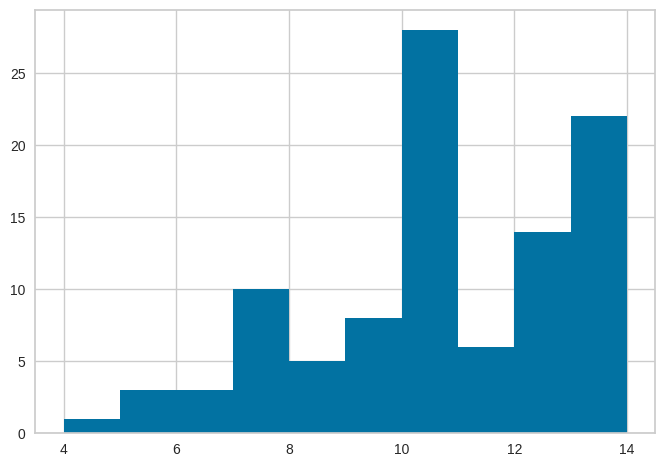

In [333]:
dias_de_pesquisa = data.groupby(['rede','endereco_completo']).agg(datas_pesquisa=('data_pesquisa','unique'),n_pesquisas=('data_pesquisa','nunique')).reset_index()
dias_de_pesquisa['intervalos'] = dias_de_pesquisa['datas_pesquisa'].apply(lambda x: intervalo_de_dias(x))
dias_de_pesquisa['n_pesquisas'].hist()

In [370]:
data.groupby(['rede','endereco_completo','id_produto','data_pesquisa']).agg(n_pesquisas=('data_pesquisa','count'))


n_pesquisas
rede                endereco_completo                                   id_produto data_pesquisa             
Agricer             Rua Antônio Zak, 363 - Alto Boqueirão - Curitiba/PR 111123     2023-09-01               2
                                                                        111132     2023-09-01               2
                                                                                   2023-09-15               2
                                                                        111148     2023-08-11               2
                                                                                   2023-08-18               2
...                                                                                                       ...
Zimmer Supermercado Rua Raul Pompéia - Cidade Industrial - Curitiba/PR  999999     2023-10-10               2
                                                                                   2023-10-17               2
                                                                                   2023-10-24               2
                                                                                   2023-10-31               2
                                                                                   2023-11-07               2

[217147 rows x 1 columns]

In [393]:
data['diff_preco_promocao'] = data.apply(lambda x: x['preco_regular'] - x['preco_promocao'] if (x['preco_regular'] > 0) & (x['preco_promocao'] > 0) else np.nan, axis = 1)

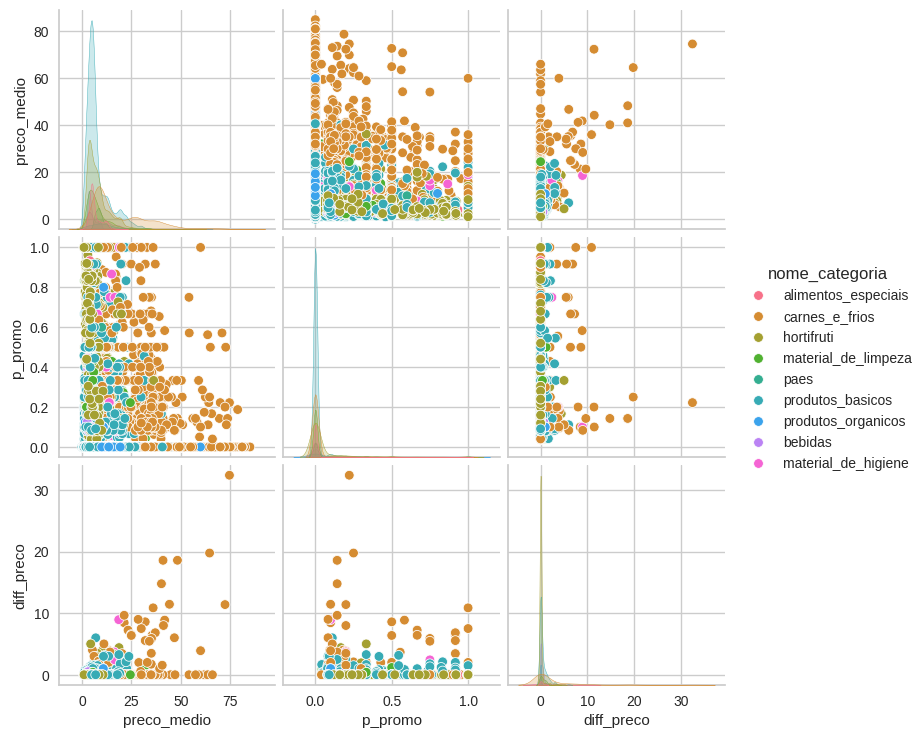

In [405]:
aux = data.groupby(['rede','endereco_completo','nome_categoria','id_produto','nome_produto','quantidade']).agg(
    preco_medio=('preco','mean'), 
    preco_min=('preco','min'),
    preco_max=('preco','max'),
    n_pesquisa=('data_pesquisa','nunique'),
    p_promo=('promocao','mean'),
    diff_preco=('diff_preco_promocao','mean')
    ).reset_index()

aux['preco_var'] = (aux['preco_max'] - aux['preco_min'])/aux['preco_min']

# sns.scatterplot(x='preco_medio',y='p_promo', hue='nome_categoria',data=aux.loc[aux['n_pesquisa']>10])
sns.pairplot(aux[['rede','preco_medio','p_promo','diff_preco','nome_categoria']],hue='nome_categoria')

In [349]:
aux = data.loc[
    (data['endereco_completo'] == 'Alameda Doutor Carlos de Carvalho 2050 - Bigorrilho - Curitiba/PR') &
    # (data['nome_produto'].str.strip() == 'CARNE BOVINA ALCATRA COM MAMINHA S/ OSSO')
    (1==1)
    ].sort_values(['data_pesquisa','nome_produto']).drop_duplicates()

aux.groupby(['rede','endereco_completo','nome_categoria','nome_produto','quantidade']).agg(preco_medio=('preco','mean'),preco_var=('preco','std'),p_promo=('promocao','mean'))

preco_medio  \
rede     endereco_completo                                                 nome_categoria      nome_produto                                    quantidade                  
Angeloni Alameda Doutor Carlos de Carvalho 2050 - Bigorrilho - Curitiba/PR alimentos_especiais ADOÇANTE EM PO                                  500 GR           4.964286   
                                                                                               CREME DE LEITE ZERO LACTOSE                     200 GR           4.550000   
                                                                                               DOCE DE LEITE ZERO LACTOSE                      350 GR          12.518000   
                                                                                               FARINHA DE ARROZ                                1 KG             8.520000   
                                                                                               FARINHA DE TRIGO INTEGRAL                       1 KG             5.777692   
                                                                                               IOGURTE DESNATADO ZERO LACTOSE                  170 GR           3.590000   
                                                                                               LEITE CONDENSADO ZERO LACTOSE                   395 GR           8.490000   
                                                                                               LEITE SEMIDESNATADO ZERO LACTOSE                1 LITRO          5.610000   
                                                                                               MACARRÃO ESPAGUETE INTEGRAL                     500 GR           5.970000   
                                                                                               MACARRÃO PARAFUSO INTEGRAL                      500 GR           5.935714   
                                                                                               MASSA ALIMENTÍCIA DE ARROZ PARAFUSO ZERO GLÚTEN 500 GR           4.864286   
                                                                                               MASSA ALIMENTÍCIA DE ARROZ PENA ZERO GLÚTEN     500 GR           4.864286   
                                                                                               MISTURA PARA BOLO INTEGRAL                      400 GR           5.704286   
                                                                                               MISTURA PARA PÃO S/GLÚTEN                       450 GR          20.545000   
                                                                           bebidas             CERVEJA ANTÁRTICA Lata                          350 ML           2.918571   
                                                                                               CERVEJA BOHEMIA Lata                            350 ML           3.504286   
                                                                                               CERVEJA BRAHMA Lata                             350 ML           3.361429   
                                                                                               CERVEJA BUDWEISER Lata                          350 ML           3.918571   
                                                                                               CERVEJA KAISER Lata                             350 ML           2.618571   
                                                                                               CERVEJA ORIGINAL Lata                           350 ML           4.170000   
                                                                                               CERVEJA SKOL Lata                               350 ML           3.004286   
                                                                                               REFRIGERANTE ( + ) BARATO Pet                   2 LITRO          4.964286   
                             

## Machine Learning

In [21]:
from yellowbrick import cluster as yb_ct
from sklearn import cluster as sk_ct
from sklearn import metrics as mt


In [17]:
X_train = aux
clusters = [2,3,4,5,6, 7, 8, 9]

In [18]:
X_train

nome_categoria,alimentos_especiais,bebidas,carnes_e_frios,hortifruti,material_de_higiene,material_de_limpeza,paes,produtos_basicos,produtos_organicos
0,0.042654,0.028436,0.158768,0.161137,0.037915,0.101896,0.026066,0.398104,0.011848
1,0.032710,0.056075,0.168224,0.182243,0.051402,0.102804,0.037383,0.359813,0.009346
2,0.051282,0.043956,0.194139,0.252747,0.036630,0.069597,0.029304,0.315018,0.007326
3,0.043147,0.030457,0.170051,0.172589,0.045685,0.104061,0.015228,0.395939,0.010152
4,0.037855,0.037855,0.176656,0.201893,0.034700,0.091483,0.031546,0.375394,0.006309
5,0.040380,0.028504,0.194774,0.166271,0.045131,0.080760,0.026128,0.368171,0.007126
6,0.043478,0.028986,0.178744,0.161836,0.048309,0.101449,0.014493,0.393720,0.007246
7,0.040881,0.031447,0.169811,0.172956,0.050314,0.088050,0.015723,0.389937,0.006289
8,0.096774,0.000000,0.129032,0.129032,0.032258,0.161290,0.064516,0.387097,0.000000
9,0.061170,0.029255,0.156915,0.151596,0.047872,0.106383,0.026596,0.404255,0.007979


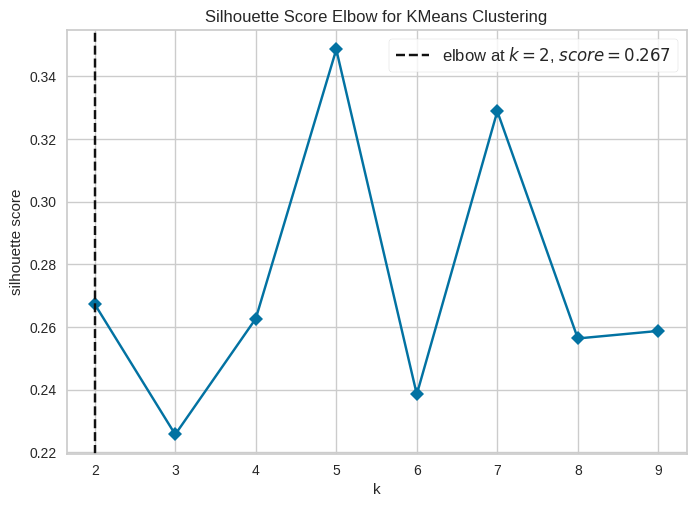

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [19]:
kmeans = yb_ct.KElbowVisualizer(sk_ct.KMeans(n_init = 10), k = clusters,metric = 'silhouette', timings = False)
kmeans.fit( X_train )
kmeans.show()

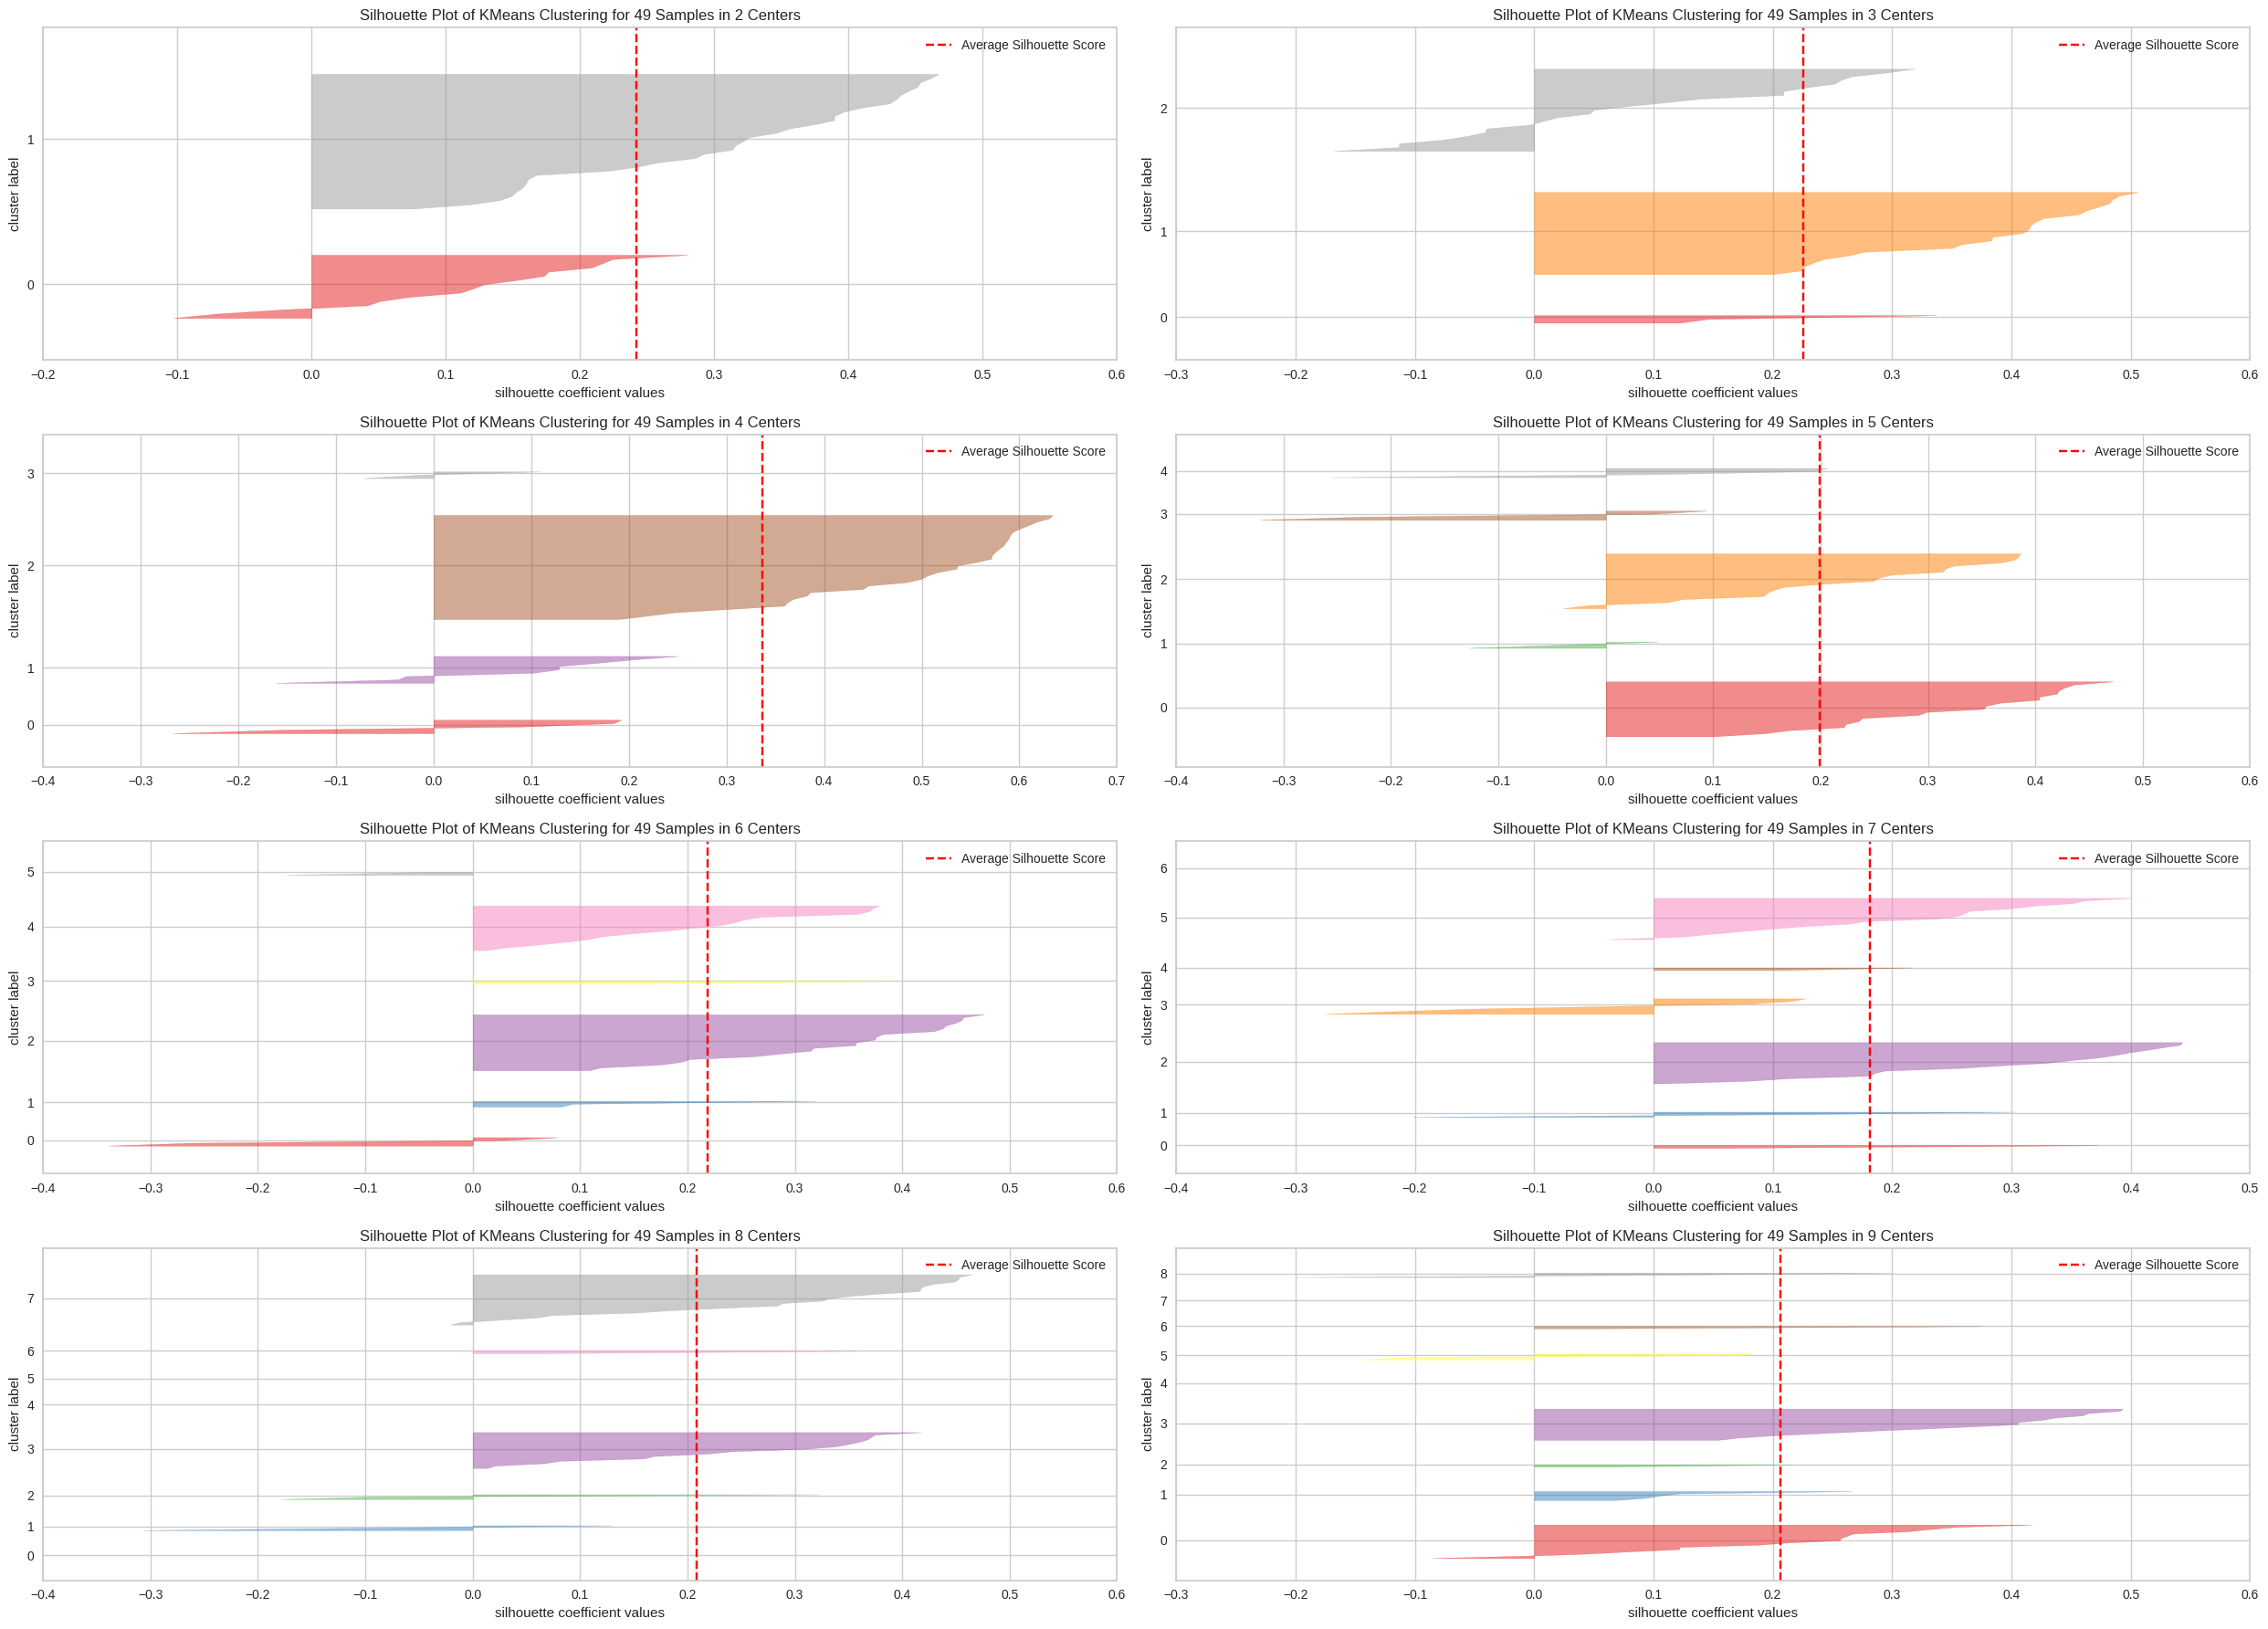

In [20]:
fig, ax = plt.subplots(4,2,figsize=(25,18))
for k in clusters:
    kn = sk_ct.KMeans(n_clusters = k, init = 'random', n_init=10, max_iter=100, random_state=42)
    
    q, mod = divmod(k,2)
    visualizer = yb_ct.SilhouetteVisualizer(kn, color='yellowbrick',ax=ax[q-1,mod])
    visualizer.fit(X_train)
    visualizer.finalize()
    plt.tight_layout()

In [22]:
# clsuter definition
k = 5

# model training
kmeans = sk_ct.KMeans(n_init = 'auto', n_clusters = k, max_iter = 500, random_state = 42)
kmeans.fit(X_train)

labels = kmeans.labels_

In [23]:
## WSS (Within Clusters Sum of Square)
print('WSS value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('SS: {}'.format(mt.silhouette_score(X_train,labels=labels, metric='euclidean')))

WSS value: 0.18409232898750857
SS: 0.19303857361455432


<AxesSubplot:xlabel='produtos_basicos', ylabel='material_de_limpeza'>

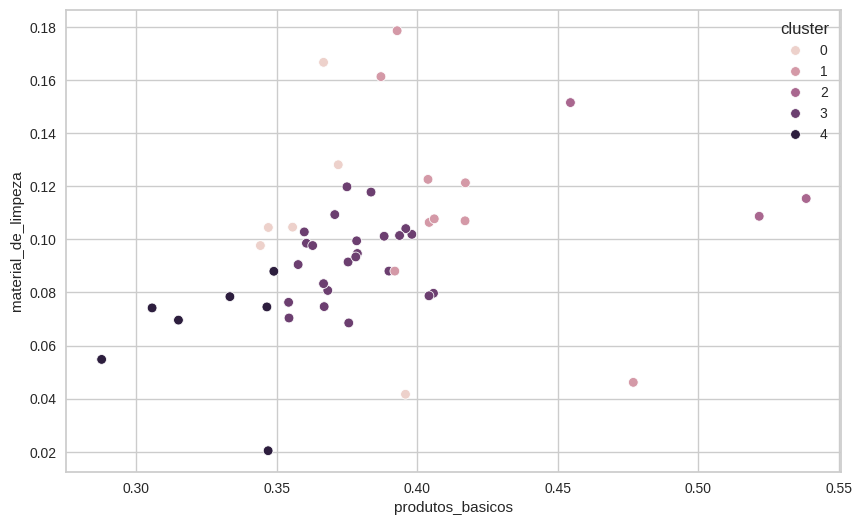

In [29]:
df_embedding = X_train.copy()

# embedding
df_embedding['cluster'] = labels

# plot UMAP
fig = plt.figure(figsize=(10,6))
sns.scatterplot(x='produtos_basicos',y='material_de_limpeza',hue = 'cluster', data=df_embedding)

In [28]:
df_embedding.columns

Index(['alimentos_especiais', 'bebidas', 'carnes_e_frios', 'hortifruti',
       'material_de_higiene', 'material_de_limpeza', 'paes',
       'produtos_basicos', 'produtos_organicos', 'cluster'],
      dtype='object', name='nome_categoria')